# Imports

In [1]:
import pandas as pd
import numpy as np
import timeit
import os
import sys
import os
import json
sys.path.append("..")

import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight,compute_class_weight
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from transformers import TFAutoModel,AutoTokenizer

from src.utils import write_metrics
from src.preprocessing import clean_tweet_for_transformers
from src.utils import read_data
from src.utils import plot_result
from src.utils import train_model, evaluate_model
from src.utils import compute_metrics
from src.utils import set_seed
#set_seed(20042022)

/home/jovyan/.conda/envs/clickbait_detection/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Training Dataset

In [2]:
#Load trainig dataset
filename = '../data/webis_train.csv'
train_df = read_data(filename)

# Cleaning Tweets

In [3]:
#Apply cleaning funcitons to tweets
train_df['cleanedText'] = train_df.postText.apply(lambda x: clean_tweet_for_transformers(x))
##Make sure that no empty string remains in 'cleanedText'
train_df  = train_df.loc[train_df.cleanedText != '']

## Plot cleaned tweet lenght distribution

21.0


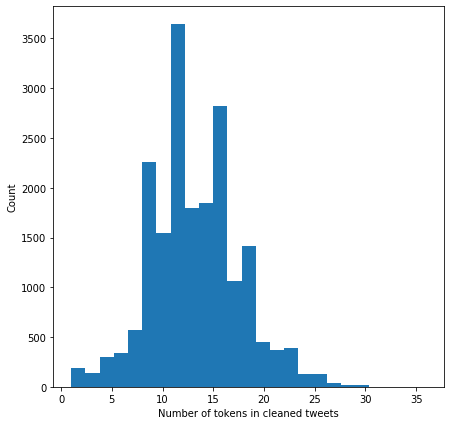

In [4]:
lenghts =  [len(x) for x in train_df['cleanedText'].str.split()]
percentile = np.percentile(lenghts,95)
print(percentile)

# Plot histogram of tweets lenght distribution in order to define the max_len parameter for the model
plt.figure(figsize=(7, 7))
plt.hist(lenghts, bins=25)
plt.xlabel('Number of tokens in cleaned tweets')
plt.ylabel('Count')
plt.show()

## Compute Class Weights

In [5]:
##Calculate class_weights to attenuate the unbalanced classification problem 
y_train = train_df.truthClass.values
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = ['no-clickbait', 'clickbait'],
                                        y = y_train                                                   
                                    )

class_weights = dict(zip([0,1], class_weights))
print(class_weights)

{0: 0.6596695557963164, 1: 2.0657336726039017}


# Model definition - BERTweet (base)

In [6]:
max_length= 40

#Setup BERTweet Model
bertweet = TFAutoModel.from_pretrained("vinai/bertweet-base")
bertweet = bertweet.layers[0]
# Build model inputs
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
# Load the Transformers BERT model as a layer into a Keras model
bertweet = bertweet(inputs)[1]
dropout = Dropout(0.2, name='pooled_output')
pooled_output = dropout(bertweet, training=False)
output = Dense(units=1, name='output', activation = 'sigmoid')(pooled_output)
model = Model(inputs=inputs, outputs=output, name='BERTweet')
model.summary()

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "BERTweet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 40)]         0                                            
__________________________________________________________________________________________________
roberta (TFRobertaMainLayer)    TFBaseModelOutputWit 134899968   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           roberta[0][1]             

## Tokenizer definition - BERTweet (base)

In [7]:
#Apply tokenizer to training data
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

x = tokenizer(
    text=train_df['cleanedText'].astype(str).to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Training

Epoch 1/100
122/122 [==============================] - 64s 521ms/step - loss: 0.4022 - accuracy: 0.8210 - val_loss: 0.3254 - val_accuracy: 0.8563
Epoch 2/100
122/122 [==============================] - 62s 508ms/step - loss: 0.3139 - accuracy: 0.8648 - val_loss: 0.3142 - val_accuracy: 0.8668
Epoch 3/100
122/122 [==============================] - 62s 509ms/step - loss: 0.2842 - accuracy: 0.8796 - val_loss: 0.3118 - val_accuracy: 0.8640
Epoch 4/100
122/122 [==============================] - 62s 508ms/step - loss: 0.2570 - accuracy: 0.8919 - val_loss: 0.3222 - val_accuracy: 0.8678
Epoch 5/100
122/122 [==============================] - 62s 507ms/step - loss: 0.2227 - accuracy: 0.9108 - val_loss: 0.3359 - val_accuracy: 0.8640
Epoch 6/100
122/122 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9228
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
122/122 [==============================] - 62s 508ms/step - loss: 0.1951 - accuracy: 0.9228 

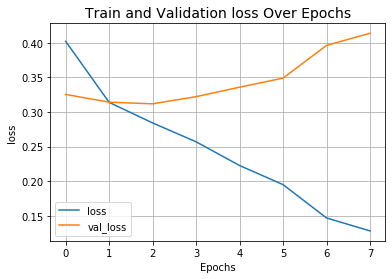

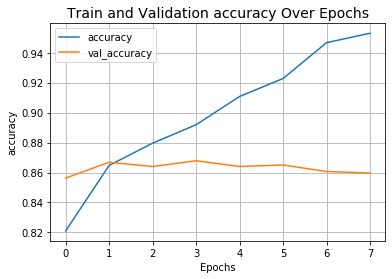

In [8]:
##Build and train BERTweet model
y_train = train_df.label.values
model, history, runtime = train_model(model, {'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']}, y_train, learning_rate=0.00001, epochs=100, batch_size=128)

### Load Test Dataset

In [9]:
# Load test dataset
filename = '../data/webis_test.csv'
test_df = read_data(filename)

In [10]:
max_seq_len = 40
#Apply same preprocessing and tokenizer to test dataset tweets
test_df['cleanedText'] = test_df.postText.apply(lambda x: clean_tweet_for_transformers(x))
test_df  = test_df.loc[test_df.cleanedText != '']

test_x = tokenizer(
    text=test_df['cleanedText'].astype(str).to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

### Evaluation

In [11]:
##Evaluate BERTweet model
y_test = test_df.label.values
predictions = evaluate_model(model, {'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']}, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

592/592 [==============================] - 33s 56ms/step - loss: 0.2926 - accuracy: 0.8708
Test loss: 0.2926306426525116
Test accuracy 0.8707767128944397

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.93      0.90      0.91     14455
   clickbait       0.71      0.77      0.74      4458

    accuracy                           0.87     18913
   macro avg       0.82      0.84      0.83     18913
weighted avg       0.88      0.87      0.87     18913



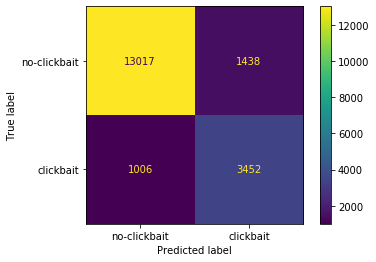

In [12]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [13]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8707767144292285
F1 Score:  0.7385537013264869
Precision Score:  0.7059304703476482
Recall Score:  0.7743382682817407


In [14]:
path = '../trained_models/BERTWEET'
if not os.path.isdir(path):
    os.mkdir(path)

##Save tokenizer to disk
tokenizer.save_pretrained(path + "/bertweet")
##Save model to disk
model.save(path + "/bertweet",save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../trained_models/BERTWEETs/bertweet/assets


In [15]:
#Save metrics and runtime
name = 'bertweet'
write_metrics(name, accuracy, f1, precision, recall, runtime, results_path = '../trained_models', results_filename = 'results.csv')  

### Training with ClassWeights

Epoch 1/100
122/122 [==============================] - 64s 527ms/step - loss: 0.3135 - accuracy: 0.8629 - val_loss: 0.4437 - val_accuracy: 0.8124
Epoch 2/100
122/122 [==============================] - 62s 510ms/step - loss: 0.2760 - accuracy: 0.8832 - val_loss: 0.4120 - val_accuracy: 0.8265
Epoch 3/100
122/122 [==============================] - 62s 510ms/step - loss: 0.2289 - accuracy: 0.9043 - val_loss: 0.4012 - val_accuracy: 0.8448
Epoch 4/100
122/122 [==============================] - 62s 507ms/step - loss: 0.1844 - accuracy: 0.9251 - val_loss: 0.4183 - val_accuracy: 0.8491
Epoch 5/100
122/122 [==============================] - 62s 508ms/step - loss: 0.1482 - accuracy: 0.9415 - val_loss: 0.4360 - val_accuracy: 0.8612
Epoch 6/100
122/122 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9537
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
122/122 [==============================] - 62s 508ms/step - loss: 0.1190 - accuracy: 0.9537 

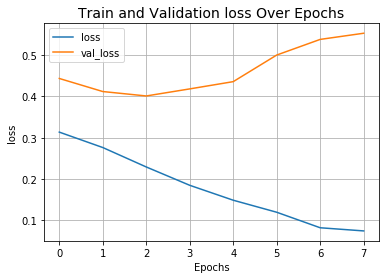

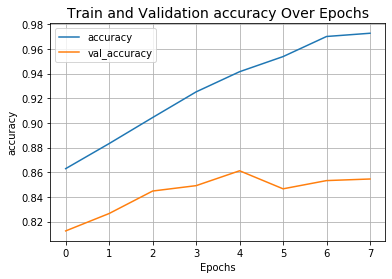

In [16]:
##Build and train BERTweet model
y_train = train_df.label.values
model, history, runtime = train_model(model, {'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']}, y_train, learning_rate=0.00001, epochs=100, batch_size=128, class_weights = class_weights)

### Evaluation

In [17]:
##Evaluate BERTweet model
predictions = evaluate_model(model, {'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']}, y_test, threshold = 0.5)
##Get Classification report
classes = ['no-clickbait', 'clickbait']
print("\nClassification report : \n", classification_report(y_test, predictions, zero_division = 0, target_names=classes))

592/592 [==============================] - 34s 57ms/step - loss: 0.3809 - accuracy: 0.8517
Test loss: 0.38092926144599915
Test accuracy 0.8517422080039978

Classification report : 
               precision    recall  f1-score   support

no-clickbait       0.94      0.86      0.90     14455
   clickbait       0.64      0.83      0.73      4458

    accuracy                           0.85     18913
   macro avg       0.79      0.84      0.81     18913
weighted avg       0.87      0.85      0.86     18913



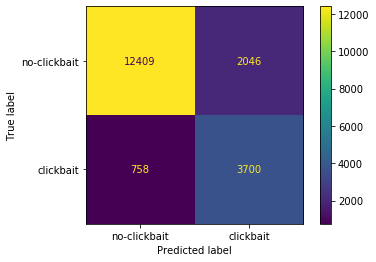

In [18]:
##Get Confusion Matrix
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot()

In [19]:
accuracy, f1, precision, recall = compute_metrics(y_test, predictions)

Accuracy Score:  0.8517421879130757
F1 Score:  0.7252058016464131
Precision Score:  0.6439262095370692
Recall Score:  0.8299685957828623


In [20]:
#Save metrics and runtime
path = '../trained_models/BERTWEET'
if not os.path.isdir(path):
    os.mkdir(path)

##Save tokenizer to disk
tokenizer.save_pretrained(path + "/bertweet_classWeigths")
##Save model to disk
model.save(path + "/bertweet_classWeigths",save_format='tf')

INFO:tensorflow:Assets written to: ../trained_models/BERTWEETs/bertweet_classWeigths/assets


In [21]:
name = 'bertweet_classWeigths'
write_metrics(name, accuracy, f1, precision, recall, runtime, results_path = '../trained_models', results_filename = 'results.csv')  